In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import ase.io as io
from ase.visualize import view

from xyz_converter import orient, to_xyz, orthogonalise
from run_prismatic import run_simulation

### Set the absolute path for the input cif file, the new xyz file for prismatic and its hdf5 file storing the simulation
The input file could be any format supported by the ASE package. To avoid unexpected behaviour of (py)prismatic, absolute paths are needed.

In [2]:
dirname = '/home/uef75971/Explore/pyprismatic_test/'

input_cif = dirname + 'AlPO4_mp-685291_conventional_standard.cif'
output_xyz = dirname + 'AlPO4_100.xyz'
output_h5 = dirname + 'AlPO4_100.h5'

atoms = io.read(input_cif)

### If the input file has the correct crystal orientation, this can be skipped.
The function `orient` can rotate the unit cell to different crystal orientation, for example if the crystal orientation along the optical axis should be [1,-1,1] (i.e. view along the zone axis [1,-1,1], `orient(atoms, [1,-1,1], new_x=[1,2,1]` will produce an ASE Atoms object with the correct orthogonal unit cell which is suitable for `prismatic`. If only the zone axis is provided, the x and y axis will be a random one (this is usually useful if you only care about the zone axis). If either the crystal axes along x or y axis is provided, they must be orthogonal to the zone axis (could provide both x and y).

For hexagonal crystal system, the four-index Miller index (Miller-Bravais) can be used.

In [3]:
rotated = orient(atoms, [1,0,0])

Crystal axis along x-axis:  None
Crystal axis along y-axis:  None
Crystal axis along z-axis:  [1 0 0]


### If the (rotated) unit cell is not orthogonal, it needs to be orthogonalised
This allows tiling of unit cell/supercell in Prismatic. Note that for the most general triclinic crystal system, usually no exact solution can be found. Even an exact solution is found, the supercell might be very huge and make simulation by `Prismatic` impractical. In such case, an approximation is suggested by increasing the `thresh` argument. The `bound` argument changes the limit of the search.

The orthogonalisation process currently uses triple for loops in Python so it is not great... this serves as a proof-of-concept and in the future this can be improved.  

In [4]:
ortho, T = orthogonalise(rotated, bound=20, thresh=0.4)

# if the original Atoms object does not have an orthogonal unit cell
# ortho, T = orthogonalise(atoms, bound=10)

Check the transformation matrix from non-orthogonal cell to orthogonal cell

In [5]:
view(ortho)
T

array([[ 0, -1, -2],
       [ 0,  1,  0],
       [ 1,  0,  0]])

### Convert the information in the Atoms object to xyz file for Prismatic

In [6]:
to_xyz(ortho, output_xyz)

# if the original Atoms object is at the correct orientation and has an orthogonal unit cell
# to_xyz(atoms, output_xyz)

### Run simulation through pyprismatic
The xyz file and the output hdf5 file path need to be provided, and it accepts any valid argument for pyprismatic simulation. The argument `alpha_max` specifies the maximum scattering angle for the detector in mrad, default to 200 mrad.

In [7]:
meta = run_simulation(output_xyz, output_h5, tileX=3, tileY=3, tileZ=3, E0=200, save2DOutput=True)

### Inspect the simulation result

In [8]:
with h5py.File(output_h5, 'r') as f:
    if meta.save3DOutput:
        stack = np.array(f['/4DSTEM_simulation/data/realslices/virtual_detector_depth0000/realslice'])
        x_A = np.array(f['/4DSTEM_simulation/data/realslices/virtual_detector_depth0000/dim1'])
        y_A = np.array(f['/4DSTEM_simulation/data/realslices/virtual_detector_depth0000/dim2'])
        bin_outer_angle = np.array(f['/4DSTEM_simulation/data/realslices/virtual_detector_depth0000/dim3'])
    
    if meta.save2DOutput:
        img = np.array(f['/4DSTEM_simulation/data/realslices/annular_detector_depth0000/realslice'])
        x_A = np.array(f['/4DSTEM_simulation/data/realslices/annular_detector_depth0000/dim1'])
        y_A = np.array(f['/4DSTEM_simulation/data/realslices/annular_detector_depth0000/dim2'])

### the 2D image from specific angular from the detector

Text(0.5, 0.98, '7.4 nm x 4.125 nm from detector angle 80 mrad to 200 mrad')

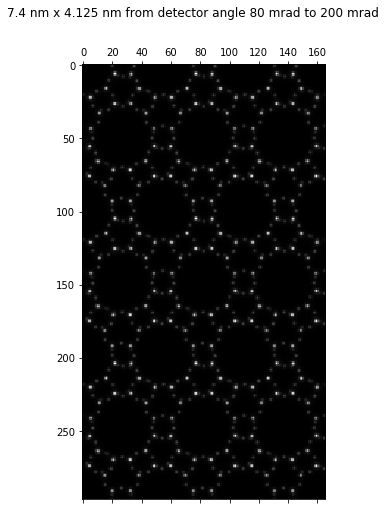

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(img, cmap='gray')
title = '{} nm x {} nm from detector angle {} mrad to {} mrad'.format(x_A[-1]/10, y_A[-1]/10, 
                                                                            meta.integrationAngleMin, 
                                                                            meta.integrationAngleMax)
fig.suptitle(title)

### Images from virtual detector

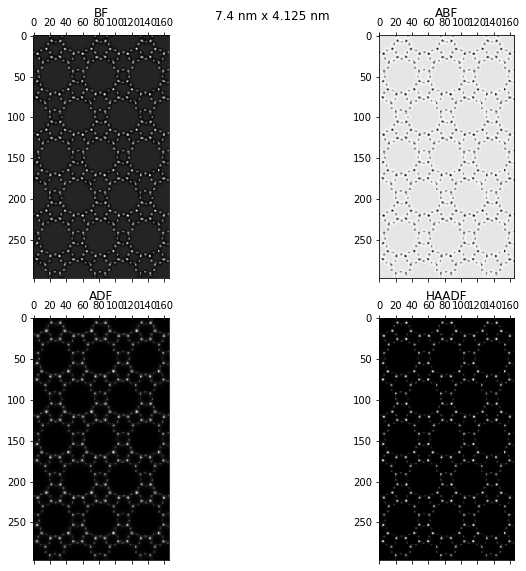

In [10]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].matshow(stack[..., :10].sum(axis=2), cmap='gray')
ax[0,0].set_title('BF')
ax[0,1].matshow(stack[..., 10:40].sum(axis=2), cmap='gray')
ax[0,1].set_title('ABF')
ax[1,0].matshow(stack[..., 40:100].sum(axis=2), cmap='gray')
ax[1,0].set_title('ADF')
ax[1,1].matshow(stack[..., 100:].sum(axis=2), cmap='gray')
ax[1,1].set_title('HAADF')

title = '{} nm x {} nm '.format(x_A[-1]/10, y_A[-1]/10)
fig.suptitle(title)
fig.tight_layout()